<a href="https://colab.research.google.com/github/BeastHunter0041/csci_4170_s26/blob/main/hw2_CSCI4170.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up:

Dataset being used for this homework is the same as HW1 (see more information in my hw1_CSCI4170 notebook.

Link: https://github.com/pkmklong/Breast-Cancer-Wisconsin-Diagnostic-DataSet/raw/master/data.csv

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.base import clone

from scipy.stats import ttest_rel


In [2]:
# Load data directly from the provided GitHub raw link
url = "https://github.com/pkmklong/Breast-Cancer-Wisconsin-Diagnostic-DataSet/raw/master/data.csv"
df = pd.read_csv(url)

# Typical columns in this dataset: id, diagnosis, features..., and sometimes an "Unnamed: 32"
df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

# Target: diagnosis (M = malignant, B = benign)
y = df["diagnosis"].map({"B": 0, "M": 1}).astype(int)

# Drop non-features (id + target)
X = df.drop(columns=["id", "diagnosis"], errors="ignore")

print("X shape:", X.shape)
print("Class balance (0=Benign, 1=Malignant):")
print(y.value_counts(normalize=True))
X.head()


X shape: (569, 30)
Class balance (0=Benign, 1=Malignant):
diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Cross-Validation Evaluation Utility Helper Function

The function below evaluates a classifier using Stratified K-Fold cross-validation, ensuring consistent class proportions across all folds.  
For each fold, it trains a fresh clone of the model and computes accuracy, precision, and F1-score, while also storing predictions.

The returned metrics are used to compare model performance across different fold settings, and the stored predictions support later analyses such as confusion matrices and paired statistical tests.


In [3]:
def evaluate_model_cv(model, X, y, n_splits, random_state=42):
    """
    Runs StratifiedKFold CV and returns per-fold metrics + predictions for each fold.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics = []
    fold_preds = []  # store (test_idx, y_true, y_pred)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        metrics = {
            "fold": fold,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0)
        }
        fold_metrics.append(metrics)
        fold_preds.append((test_idx, y_test.to_numpy(), y_pred))

    return pd.DataFrame(fold_metrics), fold_preds


# Task 1

In [4]:
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X, y)

print("Baseline tree depth:", dt_base.get_depth())
print("Baseline tree leaves:", dt_base.get_n_leaves())


Baseline tree depth: 7
Baseline tree leaves: 22


###Tree Depth Notes
- **max_depth = 2** produces a very small tree: fewer splits, easier to interpret, but typically higher bias (may underfit).
- **max_depth = 4** adds more splits and more leaf nodes: can capture more patterns, but begins increasing variance.
- **min_samples_leaf = 5** prevents tiny leaves (forces broader rules): often reduces overfitting and stabilizes decision rules, typically lowering variance.


##Sensitivity Analysis

Sensitivity analysis examines how changes in input features affect a model’s predictions or performance.  
In machine learning, it is commonly performed using:
- **Feature perturbation**, where individual inputs are varied to observe prediction changes.
- **Permutation importance**, which measures performance degradation after randomly shuffling a feature.
- **Partial Dependence Plots (PDPs)**, which show the average effect of one or two features while marginalizing over others.


References:
- Breiman, L. (2001). Random Forests; https://link.springer.com/article/10.1023/A:1010933404324
- Molnar, C. (2025). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (3rd ed.).
https://christophm.github.io/interpretable-ml-book/



In [5]:
# We'll evaluate importance using a single split (not CV) just for interpretability clarity
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X, y))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

dt_for_sensitivity = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_for_sensitivity.fit(X_train, y_train)

result = permutation_importance(
    dt_for_sensitivity, X_test, y_test,
    n_repeats=30, random_state=42, scoring="accuracy"
)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

imp.head(10)


,feature,importance_mean,importance_std
22,perimeter_worst,0.261111,0.027524
27,concave points_worst,0.135380,0.023503
7,concave points_mean,0.135088,0.021198
12,perimeter_se,0.038012,0.012474
1,texture_mean,0.018129,0.018110
17,concave points_se,0.014620,0.007625
0,radius_mean,0.003509,0.009768
5,compactness_mean,0.000000,0.000000
8,symmetry_mean,0.000000,0.000000
6,concavity_mean,0.000000,0.000000


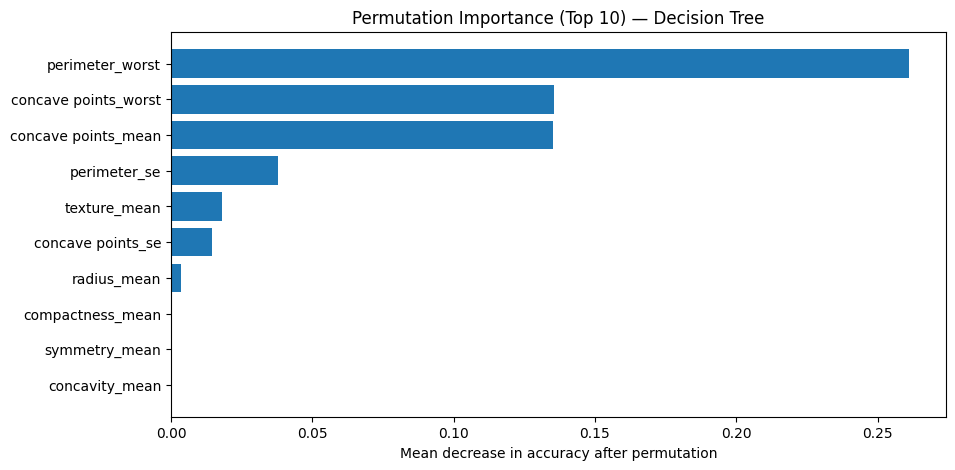

In [6]:
topk = 10
plt.figure(figsize=(10, 5))
plt.barh(imp["feature"].head(topk)[::-1], imp["importance_mean"].head(topk)[::-1])
plt.xlabel("Mean decrease in accuracy after permutation")
plt.title(f"Permutation Importance (Top {topk}) — Decision Tree")
plt.show()


Using features: perimeter_worst and concave points_worst


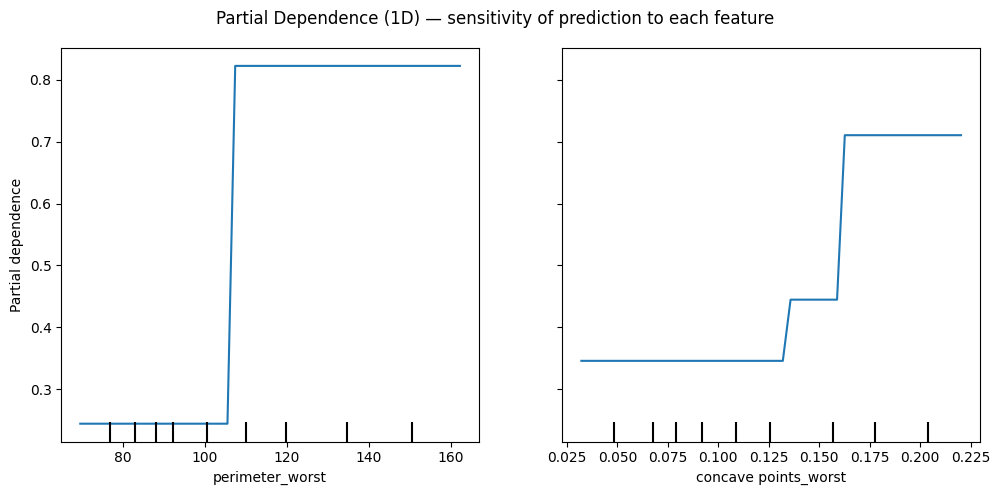

In [7]:
# Pick two impactful features (top two from permutation importance)
feat1, feat2 = imp["feature"].iloc[0], imp["feature"].iloc[1]
print("Using features:", feat1, "and", feat2)

fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    dt_for_sensitivity, X_test, features=[feat1, feat2],
    grid_resolution=50, ax=ax
)
plt.suptitle("Partial Dependence (1D) — sensitivity of prediction to each feature")
plt.tight_layout()
plt.show()


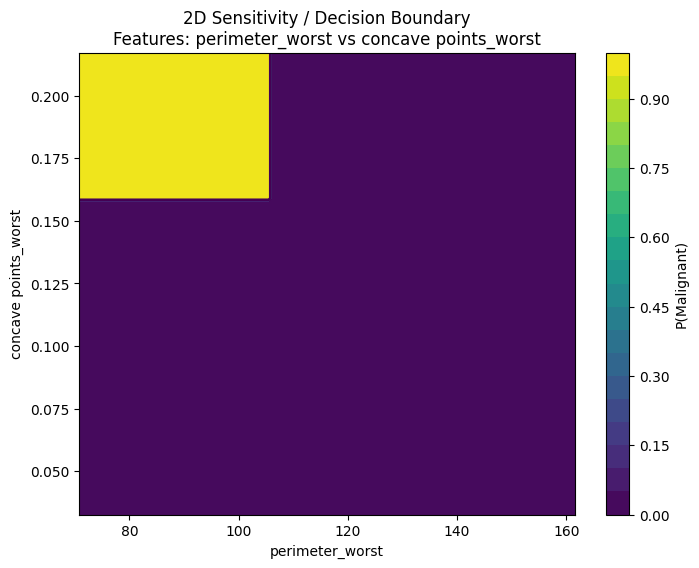

In [8]:
def plot_2d_sensitivity_boundary(model, X_ref, feature_x, feature_y, grid_points=150):
    # Fix other features at median
    base = X_ref.median()

    # Build grid for two features
    x_vals = np.linspace(X_ref[feature_x].quantile(0.05), X_ref[feature_x].quantile(0.95), grid_points)
    y_vals = np.linspace(X_ref[feature_y].quantile(0.05), X_ref[feature_y].quantile(0.95), grid_points)
    xx, yy = np.meshgrid(x_vals, y_vals)

    # Construct full feature matrix for prediction
    X_grid = pd.DataFrame(np.tile(base.to_numpy(), (grid_points * grid_points, 1)), columns=X_ref.columns)
    X_grid[feature_x] = xx.ravel()
    X_grid[feature_y] = yy.ravel()

    # Predict probability for class 1 (malignant)
    proba = model.predict_proba(X_grid)[:, 1].reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, proba, levels=20)
    plt.colorbar(contour, label="P(Malignant)")
    plt.contour(xx, yy, proba, levels=[0.5], linewidths=2)  # decision boundary at 0.5
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"2D Sensitivity / Decision Boundary\nFeatures: {feature_x} vs {feature_y}")
    plt.show()

# Use the same dt_for_sensitivity model
plot_2d_sensitivity_boundary(dt_for_sensitivity, X_test, feat1, feat2)


###Sensitivity Findings
- **Permutation importance** indicates that `perimeter_worst` is the dominant driver of the decision tree: permuting this feature reduces accuracy by ≈0.26 on average, nearly twice the impact of the next most important features (`concave_points_worst` and `concave_points_mean`, both  about 0.135). Several features (e.g., `compactness_mean`, `symmetry_mean`, `concavity_mean`) show near-zero importance, indicating they are rarely used in the learned splits.

- **Partial Dependence Plots (PDPs)** for `perimeter_worst` and `concave_points_worst` exhibit clear step-like jumps rather than smooth curves. For `perimeter_worst`, the predicted malignancy probability increases abruptly once values exceed roughly 100–110, while `concave_points_worst` shows a similar jump near 0.15. These discontinuities reflect the hard thresholding behavior of decision tree splits.

- The **2D sensitivity / decision boundary plot** shows a rectangular malignant region in the upper-left corner of the feature space, where both `perimeter_worst` and `concave_points_worst` are high. Outside this region, predicted malignancy probability remains close to zero, indicating that the model requires *both* features to cross their respective thresholds before switching class, and is largely insensitive to changes in either feature alone below those cutoffs.



# Task 2

In [9]:
# Bagging algorithm: BaggingClassifier with decision trees
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    random_state=42
)

# Boosting algorithm: AdaBoost (classic boosting)
boost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),  # stumps
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

# Baseline Decision Tree (from Task 1; use a reasonable setting)
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)


##Stratified K-Fold Cross-Validation Information
Stratified K-Fold is a k-fold CV variant that keeps the class proportions approximately the same in each fold, which is especially important in classification tasks with imbalance.

Reference:
- Molnar, C. (2025). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (3rd ed.).
https://christophm.github.io/interpretable-ml-book/


In [10]:
models = {
    "DecisionTree": dt_model,
    "Bagging": bag_model,
    "AdaBoost": boost_model
}

fold_settings = [5, 10, 15]
all_results = []

for k in fold_settings:
    for name, model in models.items():
        metrics_df, _ = evaluate_model_cv(model, X, y, n_splits=k, random_state=42)
        summary = {
            "model": name,
            "folds": k,
            "acc_mean": metrics_df["accuracy"].mean(),
            "acc_std": metrics_df["accuracy"].std(),
            "prec_mean": metrics_df["precision"].mean(),
            "prec_std": metrics_df["precision"].std(),
            "f1_mean": metrics_df["f1"].mean(),
            "f1_std": metrics_df["f1"].std(),
        }
        all_results.append(summary)

results_df = pd.DataFrame(all_results).sort_values(["folds", "acc_mean"], ascending=[True, False])
results_df


,model,folds,acc_mean,acc_std,prec_mean,prec_std,f1_mean,f1_std
2,AdaBoost,5,0.961341,0.020181,0.966631,0.026005,0.946594,0.028713
1,Bagging,5,0.956078,0.020539,0.957605,0.033075,0.939631,0.029560
0,DecisionTree,5,0.922698,0.032991,0.917745,0.046898,0.892781,0.047987
5,AdaBoost,10,0.971898,0.014770,0.977411,0.031474,0.961255,0.021565
4,Bagging,10,0.947368,0.036986,0.948994,0.055830,0.926582,0.055406
3,DecisionTree,10,0.910401,0.041659,0.898429,0.061299,0.874898,0.066632
8,AdaBoost,15,0.970128,0.021935,0.978294,0.039650,0.958572,0.032067
7,Bagging,15,0.954386,0.035119,0.958951,0.052429,0.936535,0.051387
6,DecisionTree,15,0.940256,0.033662,0.947500,0.064738,0.916672,0.049315


In [11]:
pd.set_option("display.precision", 4)
results_df


,model,folds,acc_mean,acc_std,prec_mean,prec_std,f1_mean,f1_std
2,AdaBoost,5,0.9613,0.0202,0.9666,0.0260,0.9466,0.0287
1,Bagging,5,0.9561,0.0205,0.9576,0.0331,0.9396,0.0296
0,DecisionTree,5,0.9227,0.0330,0.9177,0.0469,0.8928,0.0480
5,AdaBoost,10,0.9719,0.0148,0.9774,0.0315,0.9613,0.0216
4,Bagging,10,0.9474,0.0370,0.9490,0.0558,0.9266,0.0554
3,DecisionTree,10,0.9104,0.0417,0.8984,0.0613,0.8749,0.0666
8,AdaBoost,15,0.9701,0.0219,0.9783,0.0397,0.9586,0.0321
7,Bagging,15,0.9544,0.0351,0.9590,0.0524,0.9365,0.0514
6,DecisionTree,15,0.9403,0.0337,0.9475,0.0647,0.9167,0.0493


###Metric Behavior + Ranking
- **Accuracy** alone can mask error structure: for example, with 10-fold CV, AdaBoost achieves the highest mean accuracy (about 0.972), while the single Decision Tree lags behind (about 0.910), despite both being trained on the same data.

- **Precision** highlights clinically relevant differences: AdaBoost consistently shows the highest precision across all fold settings (about 0.967–0.978), indicating fewer false malignant predictions, whereas the Decision Tree exhibits noticeably lower precision (about 0.898 in 10-fold CV).

- **F1-score** exposes overall balance: AdaBoost maintains the strongest F1 performance across folds (about 0.946 at 5 folds, 0.961 at 10 folds, 0.959 at 15 folds), while the Decision Tree’s F1 drops substantially at 10 folds (about 0.875), indicating weaker recall–precision balance.
  
In this experiment, the ranking remains stable: **AdaBoost > Bagging > Decision Tree** across accuracy, precision, and F1. Bagging consistently improves over a single tree (e.g., F1  = 0.927 vs 0.875 at 10 folds), reflecting variance reduction, while AdaBoost’s focus on difficult samples yields the strongest overall performance without a noticeable precision–recall trade-off.



# Task 3

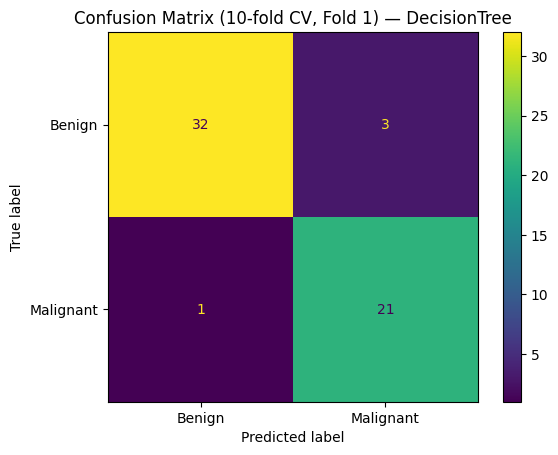

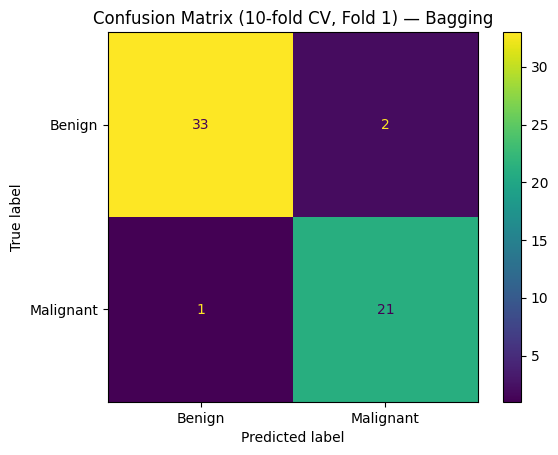

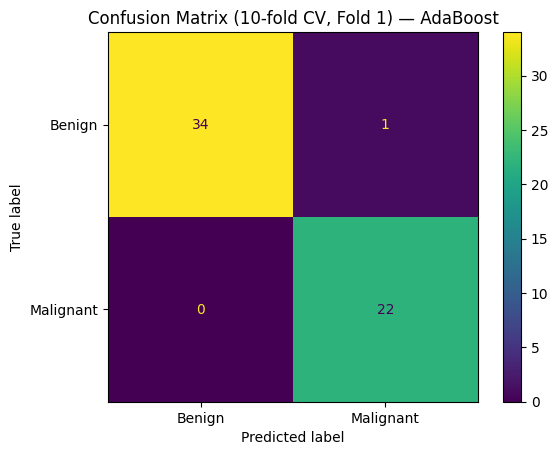

In [12]:
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X, y))  # pick the first fold

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

for name, model in models.items():
    clf = clone(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix (10-fold CV, Fold 1) — {name}")
    plt.show()


In [13]:
k = 10

acc_vectors = {}
for name, model in models.items():
    metrics_df, _ = evaluate_model_cv(model, X, y, n_splits=k, random_state=42)
    acc_vectors[name] = metrics_df["accuracy"].to_numpy()

pairs = [("DecisionTree", "Bagging"), ("DecisionTree", "AdaBoost"), ("Bagging", "AdaBoost")]

ttest_results = []
for a, b in pairs:
    tstat, pval = ttest_rel(acc_vectors[a], acc_vectors[b])
    ttest_results.append({
        "model_A": a,
        "model_B": b,
        "t_stat": tstat,
        "p_value": pval
    })

pd.DataFrame(ttest_results)


,model_A,model_B,t_stat,p_value
0,DecisionTree,Bagging,-4.3440,0.0019
1,DecisionTree,AdaBoost,-4.9880,0.0008
2,Bagging,AdaBoost,-2.2588,0.0503


### Model Comparison and Bias–Variance Trade-off

The **Single Decision Tree** shows the weakest generalization, with higher variance reflected in its confusion matrix (3 false positives and 1 false negative in the selected fold). While capable of fitting complex patterns, its instability leads to less consistent performance across folds.

**Bagging** reduces this variance by averaging multiple trees, improving classification stability (2 false positives and 1 false negative). This variance reduction translates into consistently better performance than the single tree, a difference confirmed by the paired t-test (Decision Tree vs Bagging: p = 0.0019).

**AdaBoost** achieves the strongest overall performance, eliminating false negatives entirely in the selected fold (0 FN, 22 TP) and producing only a single false positive. Its focus on hard-to-classify samples lowers bias without introducing excessive variance. Paired t-tests show statistically significant improvements over the Decision Tree (p = 0.0008), while the improvement over Bagging is smaller and borderline significant (p = 0.0503).

Overall, ensemble methods clearly outperform a single tree: Bagging primarily reduces variance, while AdaBoost further improves bias–variance balance, making it the most effective model for minimizing clinically costly errors such as missed malignant cases.
